# GATHERING DATA

In [1]:
import pandas as pd
import numpy as np 
import requests as req
import tweepy as tw
import json
from bs4 import BeautifulSoup as bs
import re
import matplotlib.pyplot as plt

### 1. Get twitter archive data 

In [2]:
twitter_archive_enhanced_old = pd.read_csv('twitter_archive_enhanced.csv')

### 2. Get image predictions file from the URL 

In [3]:
response = req.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
response_text = response.text
temp_list = []
for value in response_text.split('\n'):
    temp_list.append(value.split('\t'))
image_predictions_old = pd.DataFrame.from_records(temp_list)
header = image_predictions_old.iloc[0]
image_predictions_old = image_predictions_old[1:]
image_predictions_old.columns = header

### 3. Get tweet favorite count and retweet count using tweepy (keys and tokens are removed)

In [5]:
auth = tw.OAuthHandler('', '')
auth.set_access_token('', '')
api = tw.API(auth_handler = auth, 
             wait_on_rate_limit = True, 
             wait_on_rate_limit_notify = True, 
             parser = tw.parsers.JSONParser())

with open('tweet_json.txt', 'w') as file:
    for tweet_id in twitter_archive_enhanced.tweet_id:
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            file.write(json.dumps(tweet)+'\n')
        except Exception as e:
            print('no tweet found for tweet_id -> ' + str(tweet_id))

In [4]:
temp_list = []

with open('tweet_json.txt', 'r') as file:
    for line in file:
        json_data = json.loads(line)
        temp_list.append({'tweet_id':json_data['id'],
                          'favorites':json_data['favorite_count'],
                          'retweets':json_data['retweet_count']
                         })

tweet_fav_retweet_old = pd.DataFrame(temp_list, columns = ['tweet_id','favorites','retweets'])

# ASSESSING DATA

### 1. Twitter Archive Data

In [5]:
twitter_archive_enhanced_old.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [6]:
twitter_archive_enhanced_old.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [7]:
twitter_archive_enhanced_old.tweet_id.duplicated().any()

False

In [8]:
twitter_archive_enhanced_old.source.value_counts()
#source has html tags

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [9]:
sum(twitter_archive_enhanced_old.in_reply_to_status_id.isnull()==False)
#78 records with retweets ratings

78

In [10]:
twitter_archive_enhanced_old.rating_denominator.value_counts()
#clearly - denominator cannot be 0 - something is wrong here
#analysis can be accurate if denominator is standardized

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [11]:
twitter_archive_enhanced_old.rating_numerator.value_counts()
#numerator needs to be adjusted with denominator

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [13]:
twitter_archive_enhanced_old.name.value_counts()
#values - a, an, etc. - bad data

None          745
a              55
Charlie        12
Lucy           11
Cooper         11
Oliver         11
Penny          10
Tucker         10
Lola           10
Winston         9
Bo              9
Sadie           8
the             8
Toby            7
an              7
Bailey          7
Daisy           7
Buddy           7
Koda            6
Dave            6
Oscar           6
Milo            6
Stanley         6
Jack            6
Rusty           6
Leo             6
Scout           6
Jax             6
Bella           6
Finn            5
             ... 
by              1
Shiloh          1
Genevieve       1
Pilot           1
Edgar           1
Dug             1
Sweets          1
Leonidas        1
Coleman         1
Stephanus       1
Kona            1
Aiden           1
Major           1
Tater           1
Cal             1
Tripp           1
Champ           1
Spanky          1
Rumble          1
Rover           1
Fillup          1
Skittle         1
Cuddles         1
Banjo           1
Holly     

### 2. Image Predictions File

In [14]:
image_predictions_old.head()
#dog predictions are spread across 3 columns - need to combine in one column
#dog predictions have '_' in texts. need to remove that

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.0614285,True
2,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.07419169999999999,True,Rhodesian_ridgeback,0.07201,True
3,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.13858399999999998,True,bloodhound,0.11619700000000001,True
4,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
5,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [15]:
image_predictions_old.info()
#tweet_id is not int type to maintain consistency while merging - needs to be fixed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2076 entries, 1 to 2076
Data columns (total 12 columns):
tweet_id    2076 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null object
p1          2075 non-null object
p1_conf     2075 non-null object
p1_dog      2075 non-null object
p2          2075 non-null object
p2_conf     2075 non-null object
p2_dog      2075 non-null object
p3          2075 non-null object
p3_conf     2075 non-null object
p3_dog      2075 non-null object
dtypes: object(12)
memory usage: 194.7+ KB


In [16]:
image_predictions_old[image_predictions_old['tweet_id']=='']
#index 2076 needs to removed as it is bad data point

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2076,,None,None,None,None,None,None,None,None,None,None,None


In [17]:
image_predictions_old.tweet_id.duplicated().any()

False

In [18]:
image_predictions_old.jpg_url.duplicated().any()
#duplicates exist in jpg url

True

In [19]:
sum(image_predictions_old.jpg_url.duplicated())
#66 duplicated values - need to take care of this

66

In [20]:
image_predictions_old[image_predictions_old.jpg_url.duplicated()==True]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1298,752309394570878976,https://pbs.twimg.com/ext_tw_video_thumb/67535...,1,upright,0.303415,False,golden_retriever,0.181351,True,Brittany_spaniel,0.16208399999999998,True
1316,754874841593970688,https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg,1,pug,0.27220500000000003,True,bull_mastiff,0.25153000000000003,True,bath_towel,0.116806,False
1334,757729163776290825,https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg,2,cash_machine,0.802333,False,schipperke,0.0455186,True,German_shepherd,0.0233535,True
1346,759159934323924993,https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg,1,Irish_terrier,0.25485599999999997,True,briard,0.22771599999999997,True,soft-coated_wheaten_terrier,0.22326300000000002,True
1350,759566828574212096,https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg,1,Labrador_retriever,0.967397,True,golden_retriever,0.0166414,True,ice_bear,0.014857599999999999,False
1365,761371037149827077,https://pbs.twimg.com/tweet_video_thumb/CeBym7...,1,brown_bear,0.7132930000000001,False,Indian_elephant,0.172844,False,water_buffalo,0.0389022,False
1369,761750502866649088,https://pbs.twimg.com/media/CYLDikFWEAAIy1y.jpg,1,golden_retriever,0.586937,True,Labrador_retriever,0.39826,True,kuvasz,0.00540969,True
1388,766078092750233600,https://pbs.twimg.com/media/ChK1tdBWwAQ1flD.jpg,1,toy_poodle,0.42046300000000003,True,miniature_poodle,0.13264,True,Chesapeake_Bay_retriever,0.121523,True
1408,770093767776997377,https://pbs.twimg.com/media/CkjMx99UoAM2B1a.jpg,1,golden_retriever,0.843799,True,Labrador_retriever,0.0529559,True,kelpie,0.035711099999999996,True
1418,771171053431250945,https://pbs.twimg.com/media/CVgdFjNWEAAxmbq.jpg,3,Samoyed,0.978833,True,Pomeranian,0.012763,True,Eskimo_dog,0.00185305,True


### 3. Tweet favorite count and retweet count

In [21]:
tweet_fav_retweet_old.head()

,tweet_id,favorites,retweets
0,892420643555336193,36633,7803
1,892177421306343426,31562,5780
2,891815181378084864,23773,3825
3,891689557279858688,39950,7971
4,891327558926688256,38153,8604


In [22]:
tweet_fav_retweet_old.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
tweet_id     2331 non-null int64
favorites    2331 non-null int64
retweets     2331 non-null int64
dtypes: int64(3)
memory usage: 54.7 KB


In [23]:
tweet_fav_retweet_old.tweet_id.duplicated().any()

False

### Data issues identified - Summary

1. Twitter Archive Data - denominator is 0 - ratings extracted are not accurate
2. Twitter Archive Data - denominator is not normalized - can lead to inaccurate analysis
3. Twitter Archive Data - numerator needs to be adjusted with denominator being normalized
4. Twitter Archive Data - column name has value like - 'a', 'an', etc.
5. Twitter Archive Data - timestamp column is not broken down into individual components - year, month, date.
6. Twitter Archive Data - there are html tags in source column - it is not a clean way to pursue analysis
7. Twitter Archive Data - we have rows with retweeted ratings - can lead to misleading analysis
8. Image Predictions - bad characters present in the prediction values
9. Image Predictions - data type incorrect for tweet id column - can lead to issues while merging data
10. Image Predictions - tweet ids are null - remove such bad data points
11. Image Predictions - 66 duplicates exist in jpg_url column
12. Image Predictions - multiple columns for image predictions - combine them into one with best dog breed predictions

# CLEANING DATA

## 1. Messy Data

### 1.1 Twitter Archive Data
        a.Delete retweeted rows to maintain original ratings
        b.Source column has html tags with hyperlinks
        c.Dropping columns as they wont be used in the analysis
        d.Dog names are 'a','an,'all','None','such' values
        e.Separate timestamp into year, month, day, time fields
        f.Gather accurate rating extraction from text

### 1.2 Image Predictions
        a.Breed names have '_' in values
        b.Tweet_id is not int datatype
        c.Delete duplicated data/jpg_url column

## 2. Untidy Data

### 2.1 Twitter Archive Data 
        a.Dog stages are in different columns

### 2.2 Image Predictions
        a.Image predictions are in different columns

In [24]:
twitter_archive_enhanced = twitter_archive_enhanced_old.copy()
image_predictions = image_predictions_old.copy()
tweet_fav_retweet = tweet_fav_retweet_old.copy()

In [25]:
#DQ issue 1 - Delete retweeted rows to maintain original ratings
twitter_archive_enhanced = twitter_archive_enhanced[pd.isnull(twitter_archive_enhanced.in_reply_to_status_id)] 
twitter_archive_enhanced.drop(columns = ['in_reply_to_status_id','in_reply_to_user_id'], inplace=True)

In [26]:
# Test for DQ issue 1
twitter_archive_enhanced.sample(2)

,tweet_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1979,672980819271634944,2015-12-05 03:28:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Extraordinary dog here. Looks large. Just a he...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672980819...,5,10,None,None,None,None,None
736,780931614150983680,2016-09-28 00:46:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I want to finally rate this iconic puppo who t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/780931614...,13,10,None,None,None,None,puppo


In [27]:
#DQ issue 2 - source has html tags with hyperlinks
twitter_archive_enhanced['source'] = [bs(x, 'html').a.text for x in twitter_archive_enhanced['source']]

/opt/conda/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /opt/conda/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [28]:
#Test - DQ issue 2
twitter_archive_enhanced.source.unique()

array(['Twitter for iPhone', 'Twitter Web Client', 'Vine - Make a Scene',
       'TweetDeck'], dtype=object)

In [29]:
#DQ issue 3 - Dropping columns as they wont be used in the analysis
twitter_archive_enhanced.drop(columns=['retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'], inplace=True)

In [30]:
twitter_archive_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2278 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2278 non-null int64
timestamp             2278 non-null object
source                2278 non-null object
text                  2278 non-null object
expanded_urls         2274 non-null object
rating_numerator      2278 non-null int64
rating_denominator    2278 non-null int64
name                  2278 non-null object
doggo                 2278 non-null object
floofer               2278 non-null object
pupper                2278 non-null object
puppo                 2278 non-null object
dtypes: int64(3), object(9)
memory usage: 231.4+ KB


In [31]:
#DQ issue 4 - dog names are 'a','an,'all','None','such'...
new_names = []
names = twitter_archive_enhanced.name
for name in names:
    if(name=='None'):
        new_names.append('')
    elif(name.istitle()):
        new_names.append(name)
    else:
        new_names.append('')
twitter_archive_enhanced['name_new'] = new_names
twitter_archive_enhanced.drop(columns = ['name'], inplace=True)

In [32]:
#Test - DQ issue 4
twitter_archive_enhanced[twitter_archive_enhanced.name_new.str.istitle()==False].name_new.unique()

array([''], dtype=object)

In [33]:
#DQ issue 5 - separate timestamp into year, month, day, time fields
years = []
months = []
dates = []
times = []
for value in twitter_archive_enhanced.timestamp.str.split(' '):
    year, month, date = value[0].split('-')
    time = value[1]
    years.append(year)
    months.append(month)
    dates.append(date)
    times.append(time)
twitter_archive_enhanced['year']=years
twitter_archive_enhanced['month']=months
twitter_archive_enhanced['date']=dates
twitter_archive_enhanced['time']=times
twitter_archive_enhanced.drop(columns = ['timestamp'], inplace=True)

In [34]:
#Test - DQ issue 5
twitter_archive_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2278 entries, 0 to 2355
Data columns (total 15 columns):
tweet_id              2278 non-null int64
source                2278 non-null object
text                  2278 non-null object
expanded_urls         2274 non-null object
rating_numerator      2278 non-null int64
rating_denominator    2278 non-null int64
doggo                 2278 non-null object
floofer               2278 non-null object
pupper                2278 non-null object
puppo                 2278 non-null object
name_new              2278 non-null object
year                  2278 non-null object
month                 2278 non-null object
date                  2278 non-null object
time                  2278 non-null object
dtypes: int64(3), object(12)
memory usage: 284.8+ KB


In [35]:
#DQ issue 6 - Extract accurate ratings from text
num = []
deno = []
for text in twitter_archive_enhanced.text:
    ret_val = re.search('(\d*\.?\d+\/\d+)', text).group(1)
    num.append(float(str(ret_val).split('/')[0]))
    deno.append(float(str(ret_val).split('/')[1]))
twitter_archive_enhanced['rating_numerator_new'] = num
twitter_archive_enhanced['rating_denominator_new'] = deno

#ratings numerator below 1 is always because the string doesnt have spaces in between text and ratings. replacing them with orig values
for index, row in twitter_archive_enhanced[twitter_archive_enhanced['rating_numerator_new'] < 1].iterrows():
    twitter_archive_enhanced.loc[index,'rating_numerator_new'] = float(row.rating_numerator)

#normalize denominators to 10 for better analysis
for index, row in twitter_archive_enhanced.query('rating_denominator_new!=10.0').iterrows():
    twitter_archive_enhanced.loc[index,'rating_denominator_new'] = row.rating_denominator_new*(10.0/(row.rating_denominator_new))
    twitter_archive_enhanced.loc[index,'rating_numerator_new'] = row.rating_numerator_new*(10.0/(row.rating_denominator_new))

twitter_archive_enhanced.drop(columns = ['rating_numerator', 'rating_denominator'], inplace=True)

In [36]:
#Test DQ issue - 6
twitter_archive_enhanced.rating_denominator_new.unique()

array([ 10.])

In [37]:
#Test DQ issue - 6
twitter_archive_enhanced.rating_numerator_new.isnull().any(), twitter_archive_enhanced.rating_numerator_new.nunique(), twitter_archive_enhanced.rating_numerator_new.unique()

(False, 25, array([  1.30000000e+01,   1.20000000e+01,   1.40000000e+01,
          1.35000000e+01,   1.10000000e+01,   1.00000000e+01,
          6.00000000e+00,   1.50000000e+01,   0.00000000e+00,
          9.75000000e+00,   7.00000000e+00,   9.00000000e+00,
          3.42857143e+01,   8.00000000e+00,   1.00000000e+00,
          5.00000000e+00,   1.12700000e+01,   3.00000000e+00,
          8.18181818e+00,   4.00000000e+00,   1.77600000e+03,
          2.00000000e+00,   6.36363636e+00,   1.12600000e+01,
          4.20000000e+02]))

In [38]:
#DQ issue 7 - image predictions have '_' in breed names
image_predictions['p1'] = image_predictions['p1'].str.replace('_',' ').str.title()
image_predictions['p2'] = image_predictions['p2'].str.replace('_',' ').str.title()
image_predictions['p3'] = image_predictions['p3'].str.replace('_',' ').str.title()

In [39]:
#Test - DQ issue 7 
image_predictions.p1.str.contains('_').any(), image_predictions.p2.str.contains('_').any(), image_predictions.p3.str.contains('_').any()

(False, False, False)

In [40]:
#DQ issue 8 - tweet_id in image_predictions is not int datatype
image_predictions.drop(image_predictions[image_predictions['tweet_id']==''].index[0], inplace=True) # delete row with null tweet id
image_predictions.tweet_id = image_predictions.tweet_id.astype(int)

In [41]:
#Test - DQ issue 8
image_predictions[image_predictions['tweet_id']==0], image_predictions[image_predictions.tweet_id.isnull()]

(Empty DataFrame
 Columns: [tweet_id, jpg_url, img_num, p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog]
 Index: [], Empty DataFrame
 Columns: [tweet_id, jpg_url, img_num, p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog]
 Index: [])

In [42]:
#DQ issue 9 - delete duplicated data in image_predictions file
# image_predictions[image_predictions.jpg_url.duplicated()==True]
image_predictions=image_predictions.drop_duplicates(subset=['jpg_url'], keep='first')

In [43]:
#Test - DQ issue 9
image_predictions.jpg_url.duplicated().any()

False

In [44]:
#Tidiness Issue 1 - Dog stages are in different columns
dog_stage=[]

for index,row in twitter_archive_enhanced.iterrows():
    dog_stage.append(row['doggo'].replace('None', '').strip() + row['floofer'].replace('None', '').strip() + row['pupper'].replace('None', '').strip() + row['puppo'].replace('None', '').strip())
    
twitter_archive_enhanced['dog_stage'] = dog_stage
twitter_archive_enhanced['dog_stage'] = twitter_archive_enhanced['dog_stage'].replace('doggopupper', 'doggo,pupper').replace('doggopuppo', 'doggo,puppo').replace('doggofloofer', 'doggo,floofer')
twitter_archive_enhanced.dog_stage.value_counts()
twitter_archive_enhanced.drop(columns = ['doggo','floofer','pupper','puppo'], inplace=True)

In [45]:
#Test - Tidiness issue 1
twitter_archive_enhanced.dog_stage.nunique(), twitter_archive_enhanced.dog_stage.unique(), twitter_archive_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2278 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id                  2278 non-null int64
source                    2278 non-null object
text                      2278 non-null object
expanded_urls             2274 non-null object
name_new                  2278 non-null object
year                      2278 non-null object
month                     2278 non-null object
date                      2278 non-null object
time                      2278 non-null object
rating_numerator_new      2278 non-null float64
rating_denominator_new    2278 non-null float64
dog_stage                 2278 non-null object
dtypes: float64(2), int64(1), object(9)
memory usage: 311.4+ KB


(8, array(['', 'doggo', 'puppo', 'pupper', 'floofer', 'doggo,puppo',
        'doggo,floofer', 'doggo,pupper'], dtype=object), None)

In [46]:
#Tidiness Issue 2 - Image predictions in one column
for index,row in image_predictions.iterrows():
    if row.p1_dog=="True":
        image_predictions.loc[index, "prediction"] = row.p1
        image_predictions.loc[index, "prediction_confidence"] = row.p1_conf
    elif row.p2_dog=="True":
        image_predictions.loc[index, "prediction"] = row.p2
        image_predictions.loc[index, "prediction_confidence"] = row.p2_conf
    elif row.p3_dog=="True":
        image_predictions.loc[index, "prediction"] = row.p3
        image_predictions.loc[index, "prediction_confidence"] = row.p3_conf
    else:
        image_predictions.loc[index, "prediction"] = None
        image_predictions.loc[index, "prediction_confidence"] = None

image_predictions.drop(columns=['p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], inplace=True)

In [47]:
image_predictions.info(), image_predictions.prediction.nunique(), image_predictions.prediction.unique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2009 entries, 1 to 2075
Data columns (total 5 columns):
tweet_id                 2009 non-null int64
jpg_url                  2009 non-null object
img_num                  2009 non-null object
prediction               1691 non-null object
prediction_confidence    1691 non-null object
dtypes: int64(1), object(4)
memory usage: 174.2+ KB


(None, 113, array(['Welsh Springer Spaniel', 'Redbone', 'German Shepherd',
        'Rhodesian Ridgeback', 'Miniature Pinscher', 'Bernese Mountain Dog',
        None, 'Chow', 'Golden Retriever', 'Miniature Poodle',
        'Gordon Setter', 'Walker Hound', 'Pug', 'Bloodhound', 'Lhasa',
        'English Setter', 'Italian Greyhound', 'Maltese Dog',
        'Newfoundland', 'Malamute', 'Soft-Coated Wheaten Terrier',
        'Chihuahua', 'Black-And-Tan Coonhound', 'Toy Terrier',
        'Blenheim Spaniel', 'Pembroke', 'Irish Terrier',
        'Chesapeake Bay Retriever', 'Curly-Coated Retriever', 'Dalmatian',
        'Ibizan Hound', 'Border Collie', 'Labrador Retriever',
        'Miniature Schnauzer', 'Airedale', 'Rottweiler',
        'West Highland White Terrier', 'Toy Poodle', 'Giant Schnauzer',
        'Vizsla', 'Siberian Husky', 'Papillon', 'Saint Bernard',
        'Tibetan Terrier', 'Borzoi', 'Beagle', 'Yorkshire Terrier',
        'Pomeranian', 'Kuvasz', 'Flat-Coated Retriever',
        '

# ASSESSING DATA QUALITY AFTER CLEANING EXCERCISE

In [48]:
twitter_archive_enhanced.sample()

,tweet_id,source,text,expanded_urls,name_new,year,month,date,time,rating_numerator_new,rating_denominator_new,dog_stage
1036,744971049620602880,Twitter for iPhone,Say hello to Indie and Jupiter. They're having...,https://twitter.com/dog_rates/status/744971049...,Indie,2016,06,20,19:11:53,12.0,10.0,


In [49]:
twitter_archive_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2278 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id                  2278 non-null int64
source                    2278 non-null object
text                      2278 non-null object
expanded_urls             2274 non-null object
name_new                  2278 non-null object
year                      2278 non-null object
month                     2278 non-null object
date                      2278 non-null object
time                      2278 non-null object
rating_numerator_new      2278 non-null float64
rating_denominator_new    2278 non-null float64
dog_stage                 2278 non-null object
dtypes: float64(2), int64(1), object(9)
memory usage: 311.4+ KB


In [50]:
image_predictions.sample()

,tweet_id,jpg_url,img_num,prediction,prediction_confidence
416,674014384960745472,https://pbs.twimg.com/media/CVqUgTIUAAUA8Jr.jpg,1,Pembroke,0.74232


In [51]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2009 entries, 1 to 2075
Data columns (total 5 columns):
tweet_id                 2009 non-null int64
jpg_url                  2009 non-null object
img_num                  2009 non-null object
prediction               1691 non-null object
prediction_confidence    1691 non-null object
dtypes: int64(1), object(4)
memory usage: 174.2+ KB


In [52]:
tweet_fav_retweet.sample()

,tweet_id,favorites,retweets
715,781308096455073793,7357,2635


In [53]:
tweet_fav_retweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
tweet_id     2331 non-null int64
favorites    2331 non-null int64
retweets     2331 non-null int64
dtypes: int64(3)
memory usage: 54.7 KB


# MERGING DATASETS

In [54]:
df_twitter = pd.merge(pd.merge(twitter_archive_enhanced, image_predictions, how='left', on=['tweet_id']), tweet_fav_retweet, how='left', on=['tweet_id'])

In [55]:
df_twitter.to_csv('df_twitter.csv', index=False)

In [56]:
df_twitter.head()

,tweet_id,source,text,expanded_urls,name_new,year,month,date,time,rating_numerator_new,rating_denominator_new,dog_stage,jpg_url,img_num,prediction,prediction_confidence,favorites,retweets
0,892420643555336193,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,Phineas,2017,08,01,16:23:56,13.0,10.0,,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,None,None,36633.0,7803.0
1,892177421306343426,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,Tilly,2017,08,01,00:17:27,13.0,10.0,,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,31562.0,5780.0
2,891815181378084864,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,Archie,2017,07,31,00:18:03,12.0,10.0,,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,23773.0,3825.0
3,891689557279858688,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,Darla,2017,07,30,15:58:51,13.0,10.0,,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,Labrador Retriever,0.16808599999999999,39950.0,7971.0
4,891327558926688256,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,Franklin,2017,07,29,16:00:24,12.0,10.0,,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,Basset,0.555712,38153.0,8604.0


# INSIGHTS AND VISUALIZATION

### Insight 1 --> From 2015 until 2017, people have been using the Twitter app on the phone to rate the posts on @WeRateDogs channel

In [57]:
df_twitter.groupby('year').source.value_counts()

year  source             
2015  Twitter for iPhone      631
      Twitter Web Client       22
      Vine - Make a Scene      13
      TweetDeck                 4
2016  Twitter for iPhone     1059
      Vine - Make a Scene      78
      TweetDeck                 7
      Twitter Web Client        5
2017  Twitter for iPhone      453
      Twitter Web Client        6
Name: source, dtype: int64

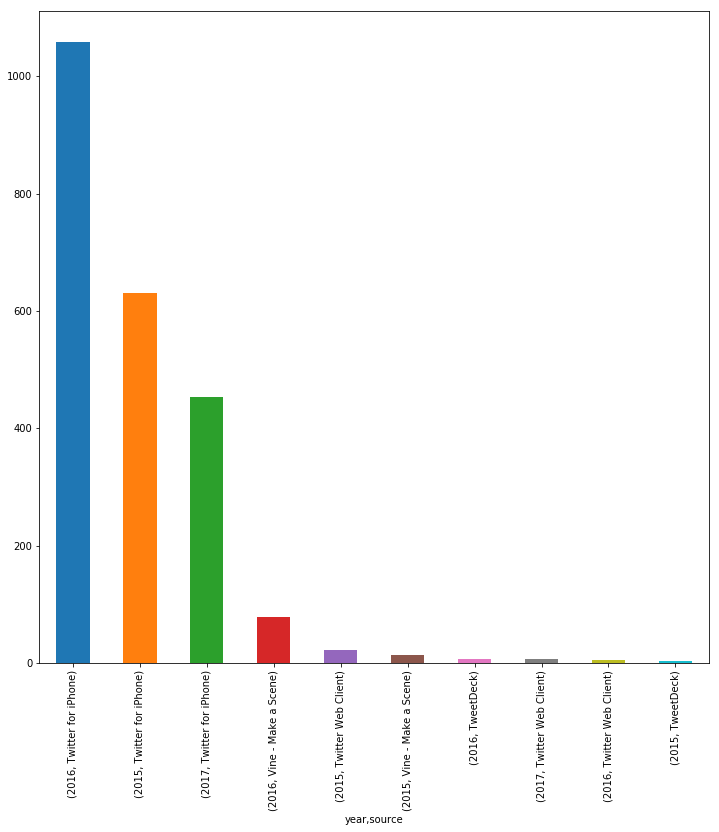

In [58]:
df_twitter.groupby('year').source.value_counts().sort_values(ascending=False).plot(kind='bar', figsize=(12,12));

### Insight 2 --> Of all the breeds, Bouvier Des Flandres has the highest average rating, followed by Saluki, Briard and Tibetian Mastiff.

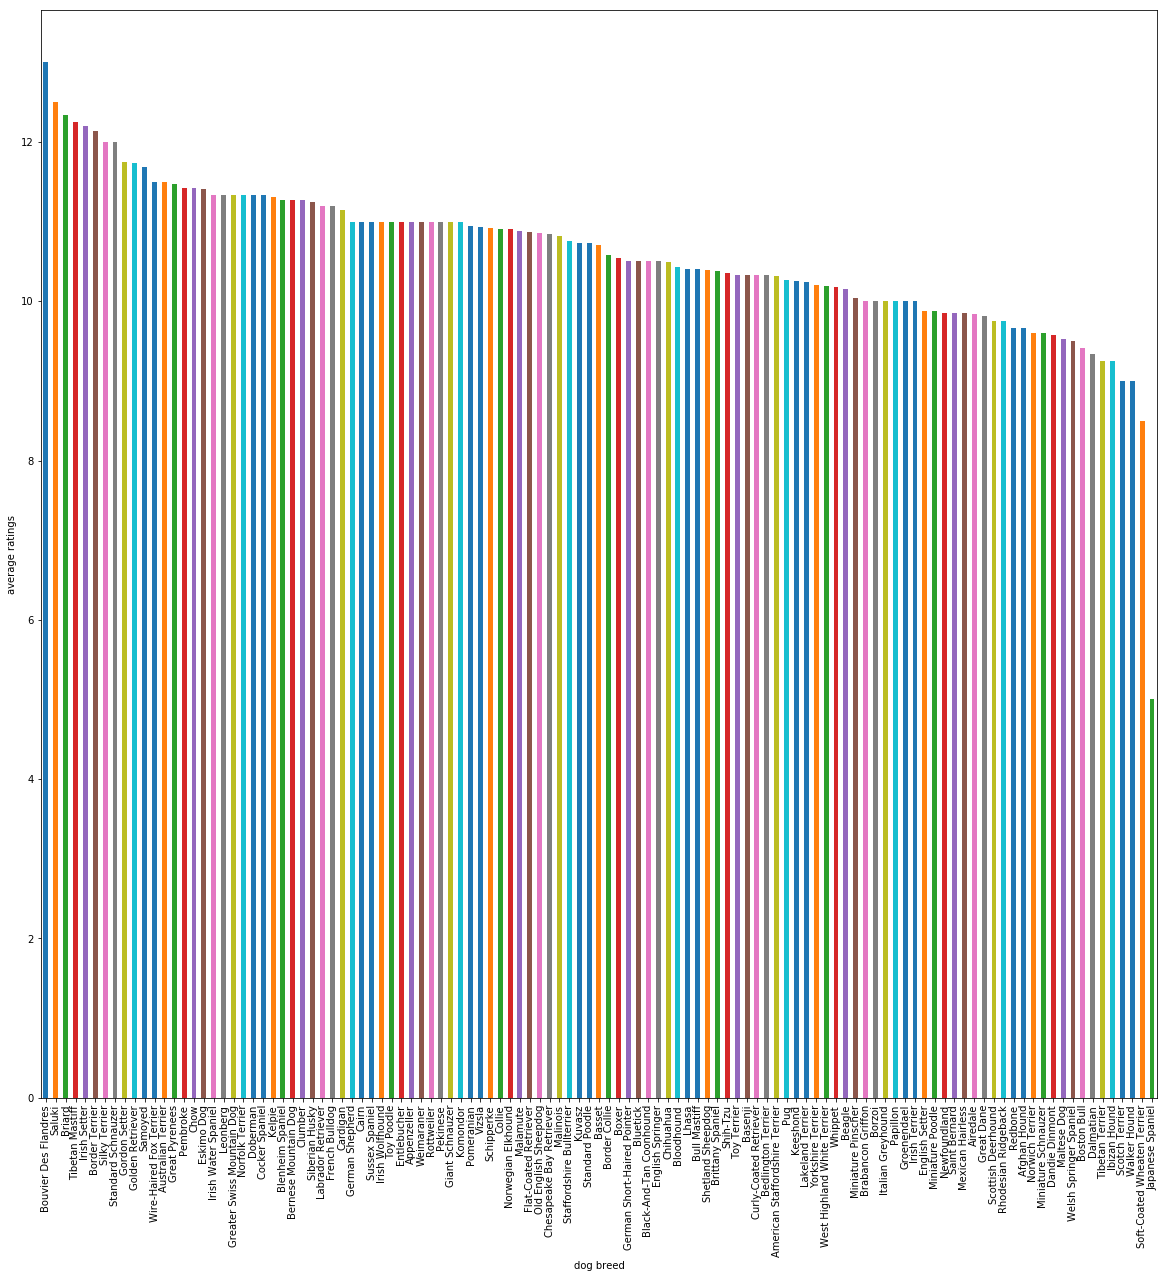

In [59]:
%matplotlib inline

df_twitter.groupby('prediction').rating_numerator_new.mean().sort_values(ascending=False).plot(kind='bar', figsize=(20,20))
plt.xlabel('dog breed');
plt.ylabel('average ratings');

In [60]:
df_twitter.groupby('prediction').rating_numerator_new.mean().sort_values(ascending=False)

prediction
Bouvier Des Flandres           13.000000
Saluki                         12.500000
Briard                         12.333333
Tibetan Mastiff                12.250000
Irish Setter                   12.200000
Border Terrier                 12.142857
Silky Terrier                  12.000000
Standard Schnauzer             12.000000
Gordon Setter                  11.750000
Golden Retriever               11.730561
Samoyed                        11.690476
Wire-Haired Fox Terrier        11.500000
Australian Terrier             11.500000
Great Pyrenees                 11.466667
Pembroke                       11.425532
Chow                           11.416667
Eskimo Dog                     11.409091
Irish Water Spaniel            11.333333
Leonberg                       11.333333
Greater Swiss Mountain Dog     11.333333
Norfolk Terrier                11.333333
Doberman                       11.333333
Cocker Spaniel                 11.333333
Kelpie                         11.307692
Blenh

### Insight 3 --> Breeds with highest favorite and retweet count are - Golden retriever, Labrador Retriever, Pembroke and Chihuahua.

In [61]:
df_twitter.groupby('prediction').favorites.sum().sort_values(ascending=False)

prediction
Golden Retriever             1827037.0
Labrador Retriever           1135608.0
Pembroke                      980850.0
Chihuahua                     726854.0
French Bulldog                568401.0
Samoyed                       522909.0
Chow                          423602.0
Cocker Spaniel                383824.0
Pug                           354393.0
Malamute                      331270.0
Toy Poodle                    299265.0
Pomeranian                    299033.0
Chesapeake Bay Retriever      288967.0
Eskimo Dog                    264668.0
Cardigan                      249297.0
German Shepherd               201067.0
Lakeland Terrier              199738.0
Basset                        185620.0
Miniature Pinscher            183987.0
Great Pyrenees                171997.0
Whippet                       149820.0
Shetland Sheepdog             142635.0
Standard Poodle               142472.0
Staffordshire Bullterrier     140206.0
Bedlington Terrier            139621.0
Italian Greyho

In [62]:
df_twitter.groupby('prediction').retweets.sum().sort_values(ascending=False)

prediction
Golden Retriever              528372.0
Labrador Retriever            351935.0
Pembroke                      262047.0
Chihuahua                     233628.0
Samoyed                       172699.0
French Bulldog                146046.0
Cocker Spaniel                131880.0
Chow                          118997.0
Pug                           105054.0
Pomeranian                    101569.0
Toy Poodle                     99069.0
Malamute                       98112.0
Eskimo Dog                     94511.0
Chesapeake Bay Retriever       74814.0
Cardigan                       70805.0
Lakeland Terrier               65814.0
Great Pyrenees                 60161.0
Standard Poodle                54287.0
Whippet                        50037.0
German Shepherd                49928.0
Miniature Pinscher             49790.0
English Springer               48415.0
Bedlington Terrier             44531.0
Basset                         44021.0
Shetland Sheepdog              38311.0
Rottweiler    

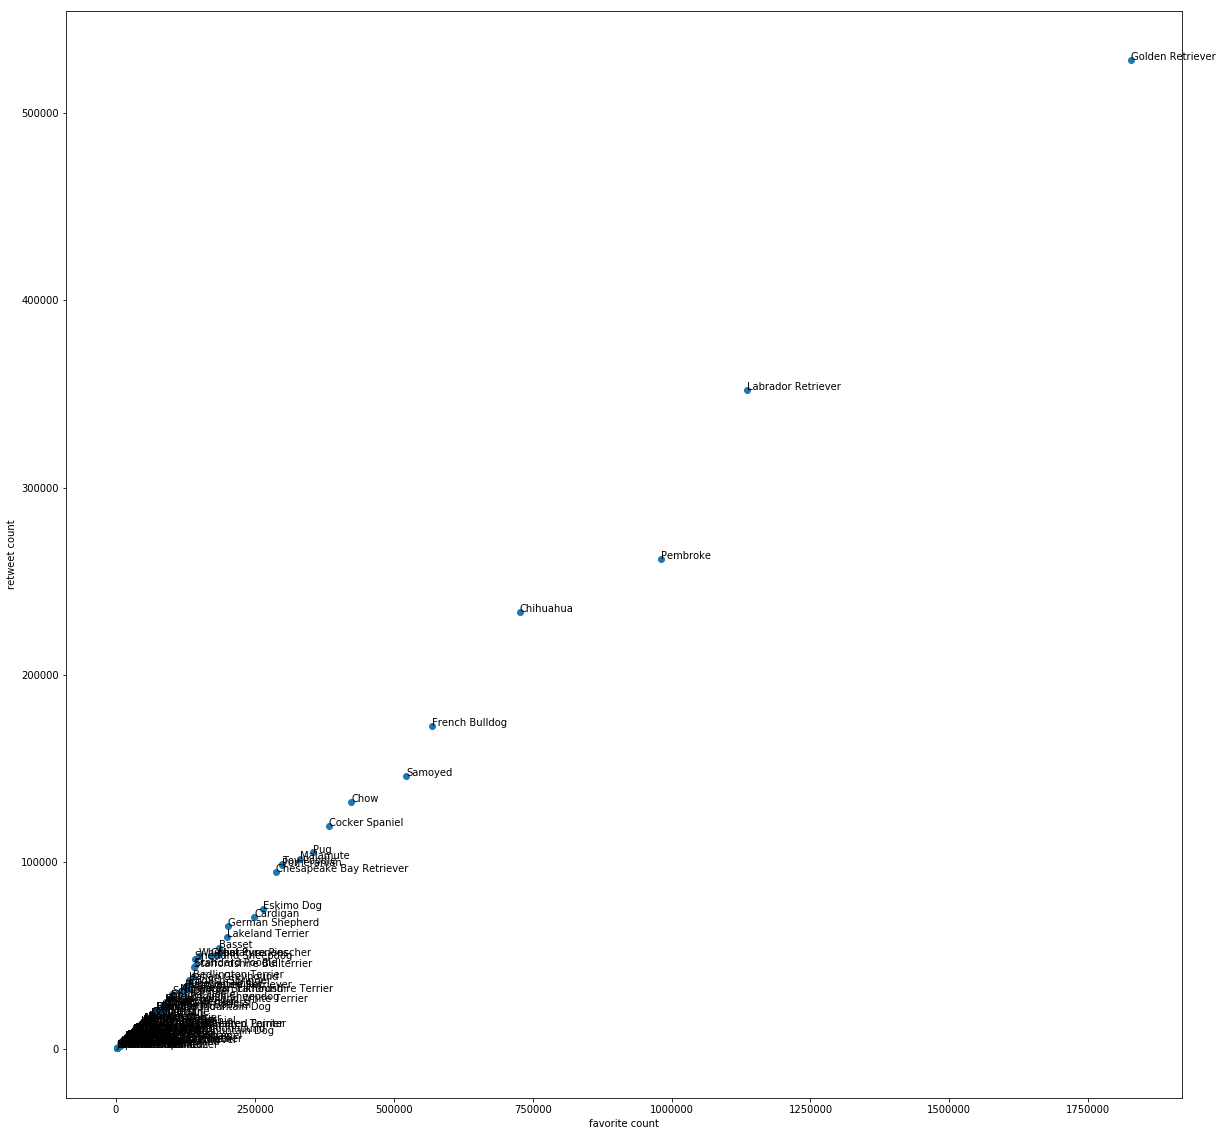

In [64]:
x = df_twitter.groupby('prediction').favorites.sum().sort_values(ascending=False)
y = df_twitter.groupby('prediction').retweets.sum().sort_values(ascending=False)
n = df_twitter.groupby('prediction').favorites.sum().sort_values(ascending=False).index
plt.scatter(x, y)
plt.xlabel('favorite count')
plt.ylabel('retweet count')

plt.rcParams["figure.figsize"] = [20,20]

for i, txt in enumerate(n):
    plt.annotate(txt, (x[i], y[i]))